# CP 322 - Final Project

Aditya Chauhan (169027493)

## Introduction

### Dataset Choice

- [Student Performance Dataset](https://archive.ics.uci.edu/dataset/320/student+performance)

### Key Research Questions:

- Can external factors such as familial support, alcohol consumption, absences, and many others, predict student's academic success?
- If they can, which model can most accurately use the factors to make the prediction?

### Imports

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
from scipy.stats import zscore
from sklearn.ensemble import RandomForestRegressor
from category_encoders import BinaryEncoder

student_mat = pd.read_csv("Data/student-mat.csv", sep=";")
student_por = pd.read_csv("Data/student-por.csv", sep=";")

## Data Exploration

### Objective & Use Case

Student success is a cornerstone of educational systems, and identifying the drivers of academic performance is critical for improving outcomes. This project utilizes the Student Performance Dataset to develop a predictive model that analyzes the factors affecting final grades (G3). By addressing key questions—like the importance of early grades (G1, G2), the role of family support, and the impact of behavioral factors—this model provides practical tools for educators and administrators to allocate resources effectively and support at-risk students.

### Dataset Overview

In [175]:
# Number of students in each dataset
print(f"Number of students in student-mat dataset: {len(student_mat)}")
print(f"Number of students in student-por dataset: {len(student_por)}")

# Missing value check
missing_values_mat = student_mat.isnull().sum()
missing_values_por = student_por.isnull().sum()

# Summary statistics for numerical columns
summary_stats_mat = student_mat.describe()
summary_stats_por = student_por.describe()

# Unique value counts for categorical columns
categorical_columns_mat = student_mat.select_dtypes(include=['object']).columns
unique_counts_mat = {col: student_mat[col].nunique() for col in categorical_columns_mat}
categorical_columns_por = student_por.select_dtypes(include=['object']).columns
unique_counts_por = {col: student_por[col].nunique() for col in categorical_columns_por}

print("\nMissing Values in mat:\n", missing_values_mat)
print("\nSummary Statistics of mat:\n", summary_stats_mat)
print("\nUnique Value Counts in mat:\n", unique_counts_mat)
print("\nMissing Values in por:\n", missing_values_por)
print("\nSummary Statistics of por:\n", summary_stats_por)
print("\nUnique Value Counts in por:\n", unique_counts_por)

Number of students in student-mat dataset: 395
Number of students in student-por dataset: 649

Missing Values in mat:
 school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

Summary Statistics of mat:
               age        Medu        Fedu  traveltime   studytime    failures  \
count  395.000000  395.000000  395.000000  395.000000  395.000000  395.000000   
mean    16.696203    2.749367    2.521519    1.448101    2.035443    0.334177   
std      1.276043    1.094735    1.088201    0.697505    0.839240   

In summary, the dataset has 0 missing values and a mix of continuous & categorical features

### Feature Analysis

- Tabular Summary
- Analysis of Continuous & Categorical Features
- Visualizations

Analyzing Covariance and Correlation for student-mat Dataset
Covariance Matrix for student-mat:
                  age      Medu      Fedu  traveltime  studytime  failures  \
age         1.628285 -0.228619 -0.226949    0.062873  -0.004434  0.231221   
Medu       -0.228619  1.198445  0.742717   -0.131061   0.059667 -0.192681   
Fedu       -0.226949  0.742717  1.184180   -0.120073  -0.008379 -0.202641   
traveltime  0.062873 -0.131061 -0.120073    0.486513  -0.059070  0.047844   
studytime  -0.004434  0.059667 -0.008379   -0.059070   0.704324 -0.108321   
failures    0.231221 -0.192681 -0.202641    0.047844  -0.108321  0.553017   
famrel      0.061717 -0.003842 -0.001337   -0.010512   0.029898 -0.029564   
freetime    0.020947  0.033779 -0.013963   -0.011861  -0.120041  0.068329   
goout       0.180364  0.078115  0.052220    0.022162  -0.059706  0.103123   
Dalc        0.149039  0.019341  0.002313    0.085941  -0.146533  0.090118   
Walc        0.192733 -0.066440 -0.017702    0.120478  -0

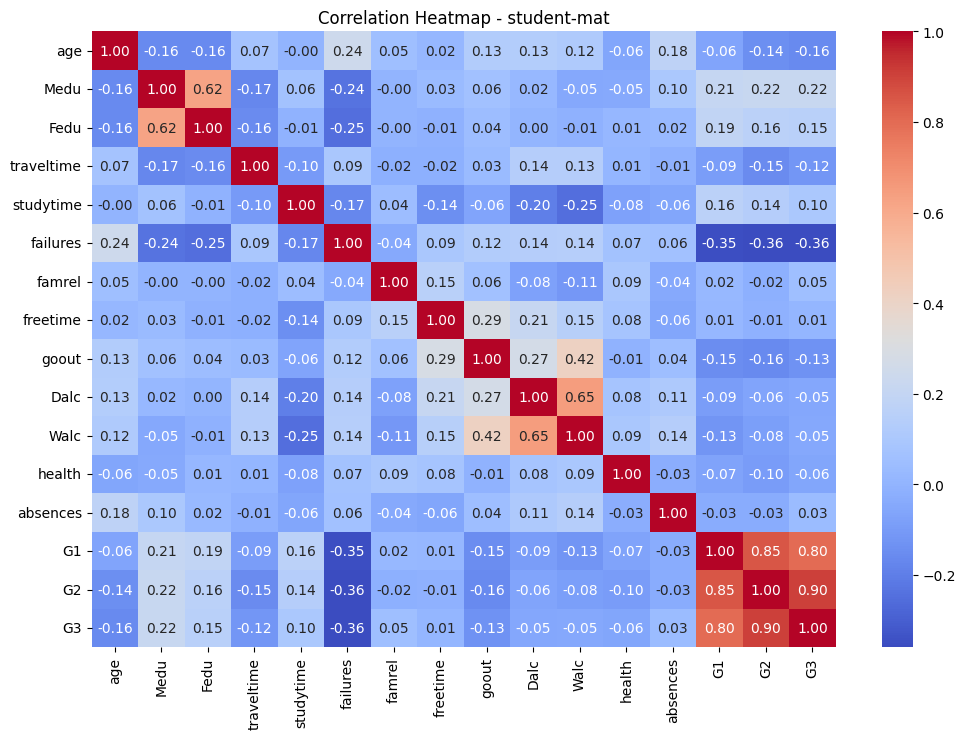

Analyzing Covariance and Correlation for student-por Dataset
Covariance Matrix for student-por:
                  age      Medu      Fedu  traveltime  studytime  failures  \
age         1.483859 -0.149028 -0.162192    0.031454  -0.008503  0.231222   
Medu       -0.149028  1.287208  0.808005   -0.225156   0.091294 -0.115907   
Fedu       -0.162192  0.808005  1.209848   -0.171520   0.045985 -0.108262   
traveltime  0.031454 -0.225156 -0.171520    0.560492  -0.039220  0.043405   
studytime  -0.008503  0.091294  0.045985   -0.039220   0.688086 -0.072555   
failures    0.231222 -0.115907 -0.108262    0.043405  -0.072555  0.351928   
famrel     -0.023935  0.026479  0.021293   -0.006812  -0.003272 -0.035518   
freetime   -0.006287 -0.023476  0.007909    0.000737  -0.060012  0.067963   
goout       0.161564  0.012721  0.035810    0.050574  -0.073579  0.031442   
Dalc        0.151827 -0.007364  0.000062    0.064270  -0.105549  0.058128   
Walc        0.135111 -0.028803  0.054312    0.054816  -0

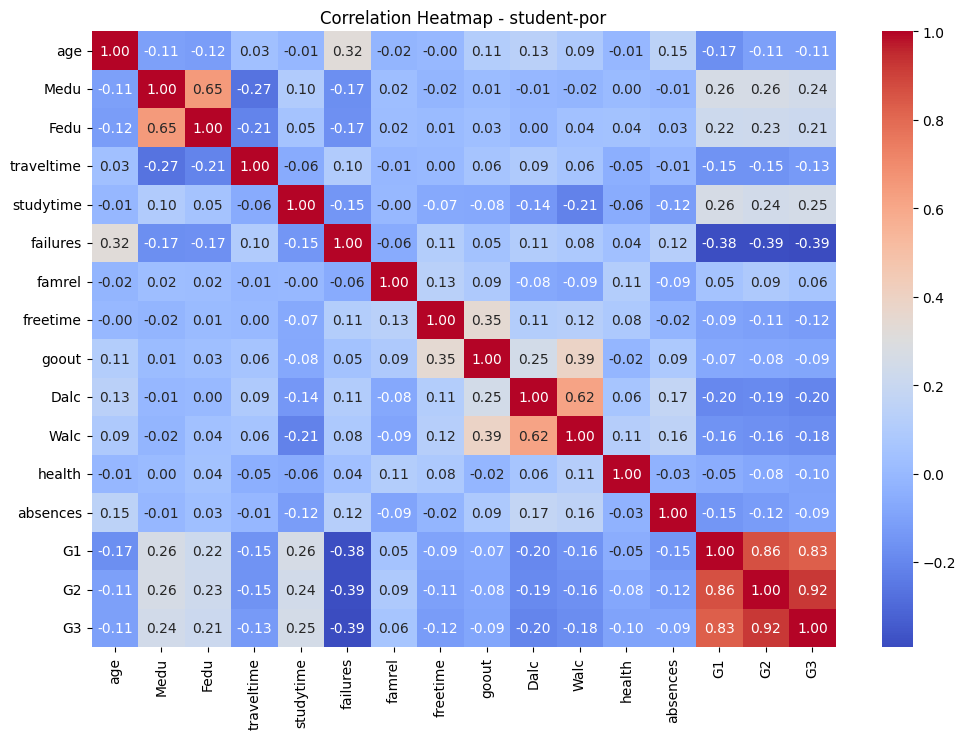

Advanced Overview for student-mat Dataset:

Numerical Summary:


,count,mean,std,min,25%,50%,75%,max,missing_values,unique_values
age,395.0,16.696203,1.276043,15.0,16.0,17.0,18.0,22.0,0,8
Medu,395.0,2.749367,1.094735,0.0,2.0,3.0,4.0,4.0,0,5
Fedu,395.0,2.521519,1.088201,0.0,2.0,2.0,3.0,4.0,0,5
traveltime,395.0,1.448101,0.697505,1.0,1.0,1.0,2.0,4.0,0,4
studytime,395.0,2.035443,0.839240,1.0,1.0,2.0,2.0,4.0,0,4
failures,395.0,0.334177,0.743651,0.0,0.0,0.0,0.0,3.0,0,4
famrel,395.0,3.944304,0.896659,1.0,4.0,4.0,5.0,5.0,0,5
freetime,395.0,3.235443,0.998862,1.0,3.0,3.0,4.0,5.0,0,5
goout,395.0,3.108861,1.113278,1.0,2.0,3.0,4.0,5.0,0,5
Dalc,395.0,1.481013,0.890741,1.0,1.0,1.0,2.0,5.0,0,5



Categorical Summary:


,unique_values,missing_values,most_frequent_value
school,2,0,GP
sex,2,0,F
address,2,0,U
famsize,2,0,GT3
Pstatus,2,0,T
Mjob,5,0,other
Fjob,5,0,other
reason,4,0,course
guardian,3,0,mother
schoolsup,2,0,no


Advanced Overview for student-por Dataset:

Numerical Summary:


,count,mean,std,min,25%,50%,75%,max,missing_values,unique_values
age,649.0,16.744222,1.218138,15.0,16.0,17.0,18.0,22.0,0,8
Medu,649.0,2.514638,1.134552,0.0,2.0,2.0,4.0,4.0,0,5
Fedu,649.0,2.306626,1.099931,0.0,1.0,2.0,3.0,4.0,0,5
traveltime,649.0,1.568567,0.748660,1.0,1.0,1.0,2.0,4.0,0,4
studytime,649.0,1.930663,0.829510,1.0,1.0,2.0,2.0,4.0,0,4
failures,649.0,0.221880,0.593235,0.0,0.0,0.0,0.0,3.0,0,4
famrel,649.0,3.930663,0.955717,1.0,4.0,4.0,5.0,5.0,0,5
freetime,649.0,3.180277,1.051093,1.0,3.0,3.0,4.0,5.0,0,5
goout,649.0,3.184900,1.175766,1.0,2.0,3.0,4.0,5.0,0,5
Dalc,649.0,1.502311,0.924834,1.0,1.0,1.0,2.0,5.0,0,5



Categorical Summary:


,unique_values,missing_values,most_frequent_value
school,2,0,GP
sex,2,0,F
address,2,0,U
famsize,2,0,GT3
Pstatus,2,0,T
Mjob,5,0,other
Fjob,5,0,other
reason,4,0,course
guardian,3,0,mother
schoolsup,2,0,no


Exploring G3 (Final Grade) in student-mat Dataset:


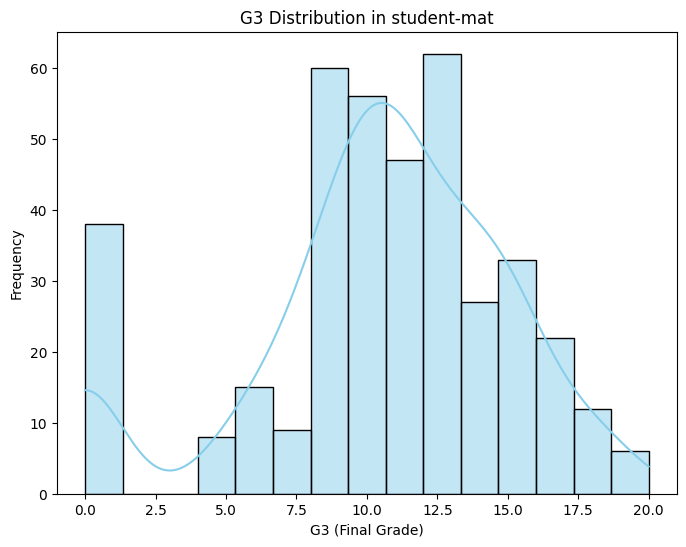

Exploring G3 (Final Grade) in student-por Dataset:


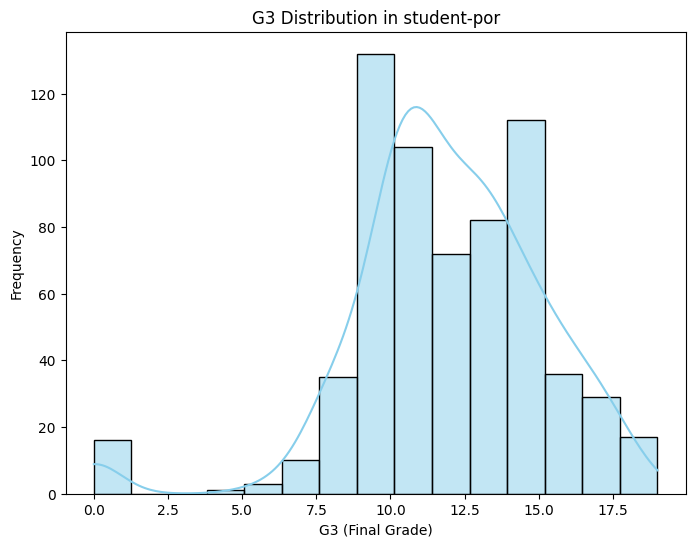

Feature Importance Exploration for student-mat Dataset:

Feature Importance:


,Feature,Importance
31,G2,0.738437
29,absences,0.154388
2,age,0.033211
10,reason,0.031903
13,studytime,0.010554
30,G1,0.007035
27,Walc,0.003385
24,freetime,0.002654
25,goout,0.002645
12,traveltime,0.001844


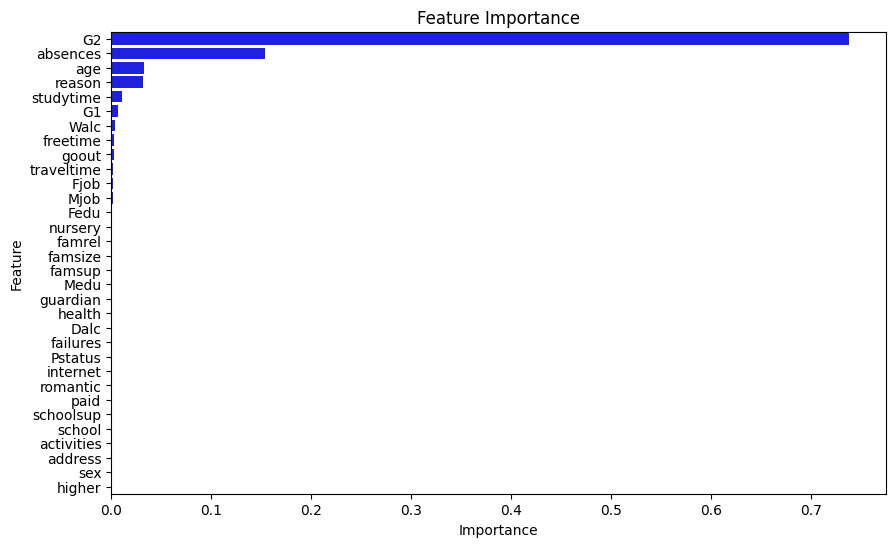

Feature Importance Exploration for student-por Dataset:

Feature Importance:


,Feature,Importance
31,G2,0.835501
29,absences,0.025762
25,goout,0.022148
1,sex,0.017793
0,school,0.016569
7,Fedu,0.015101
30,G1,0.010573
24,freetime,0.006153
19,nursery,0.005590
23,famrel,0.005279


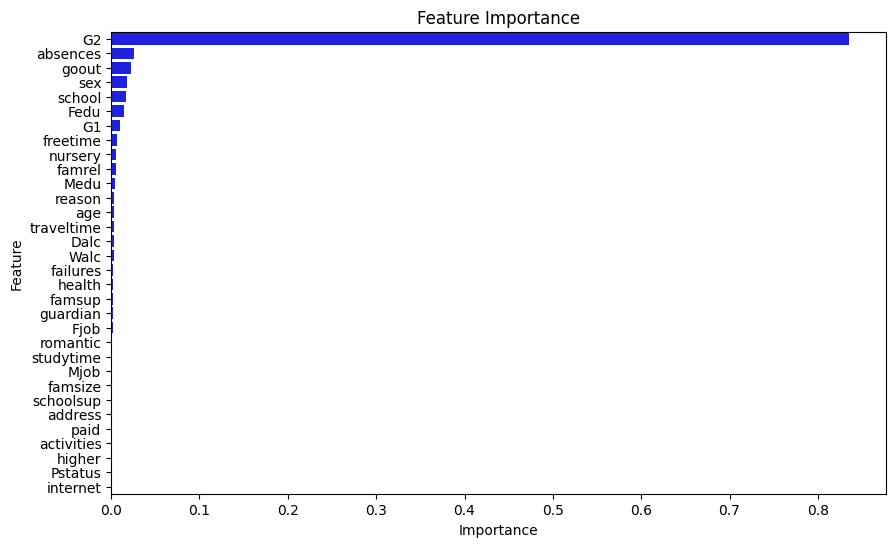

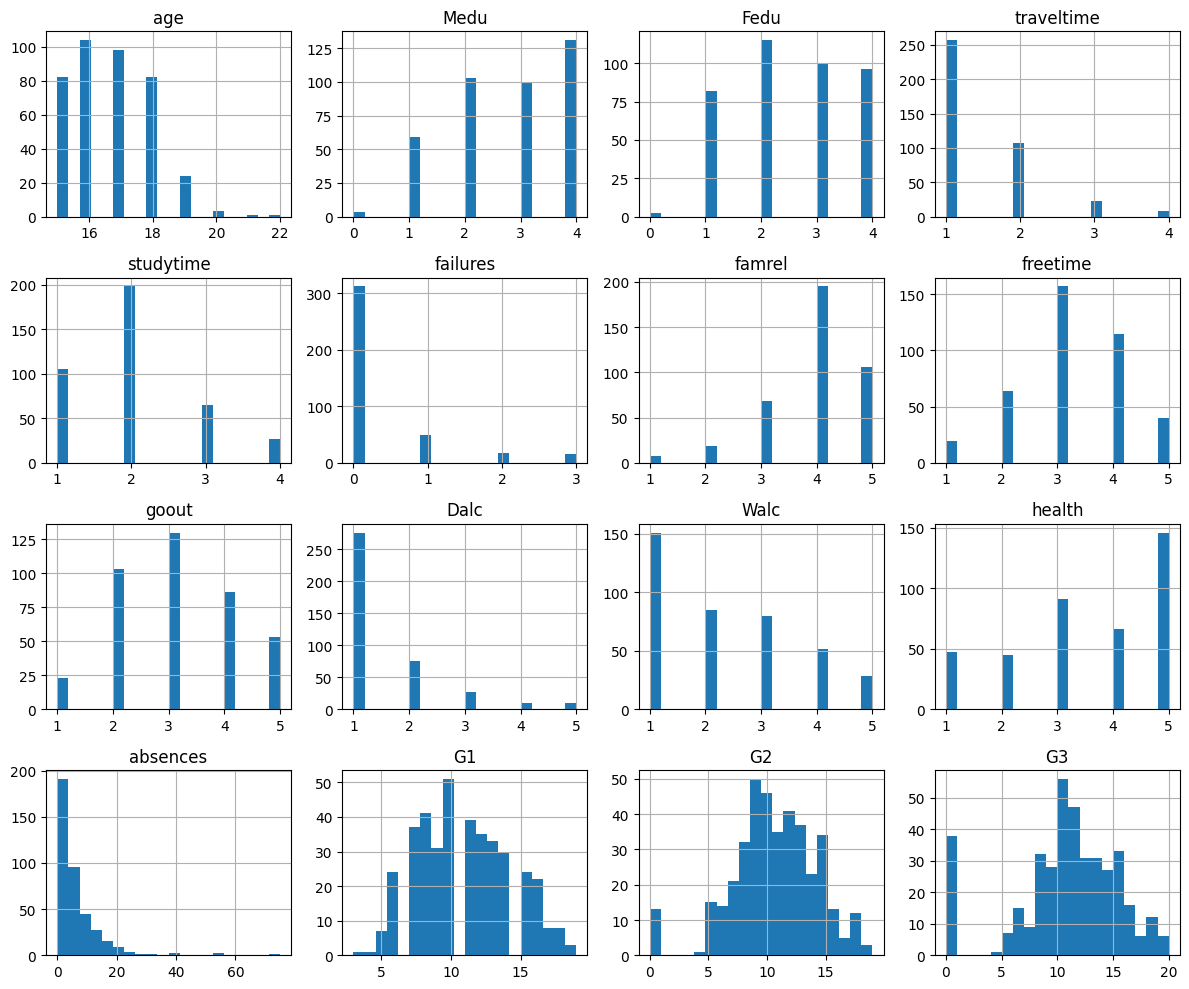

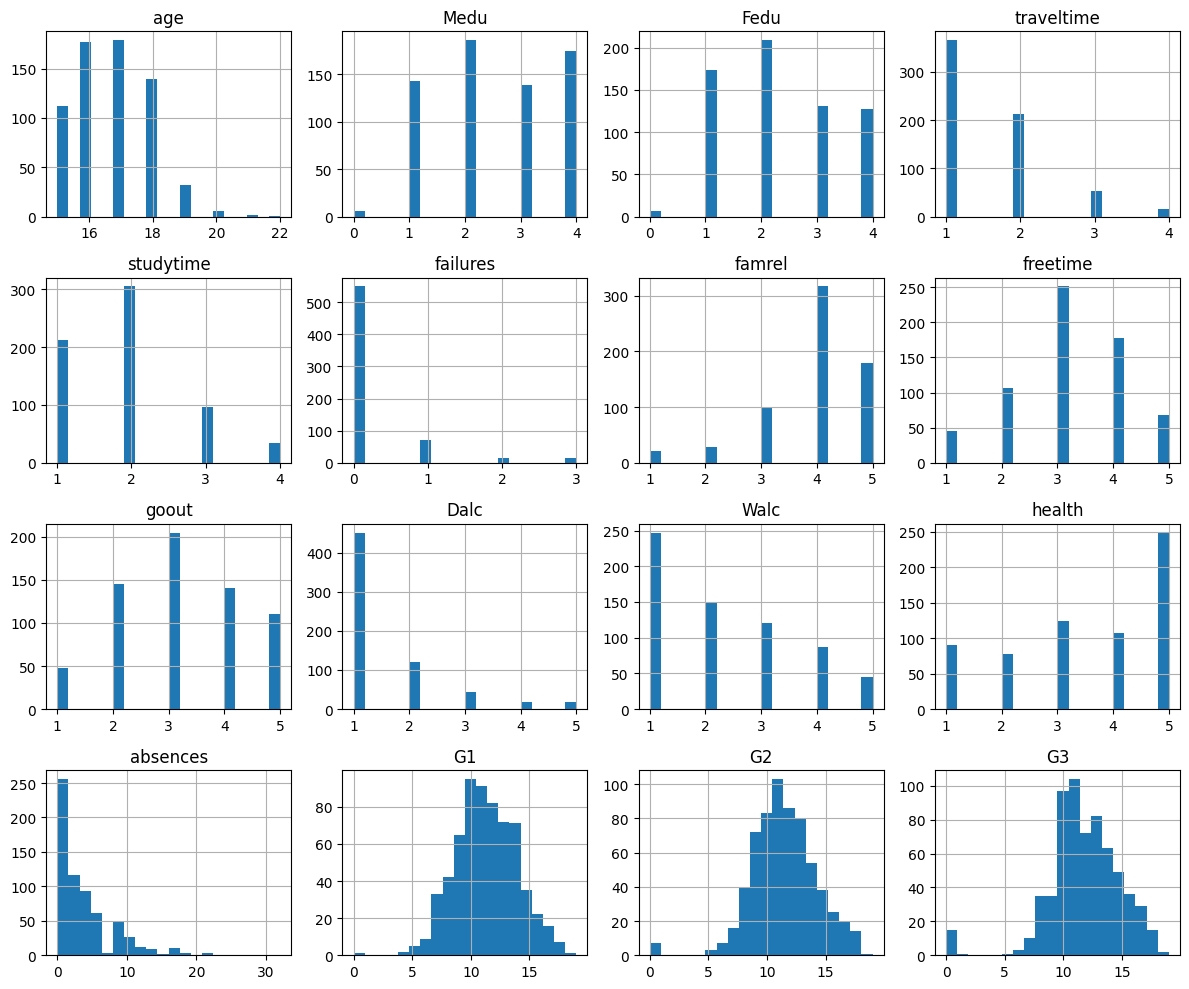

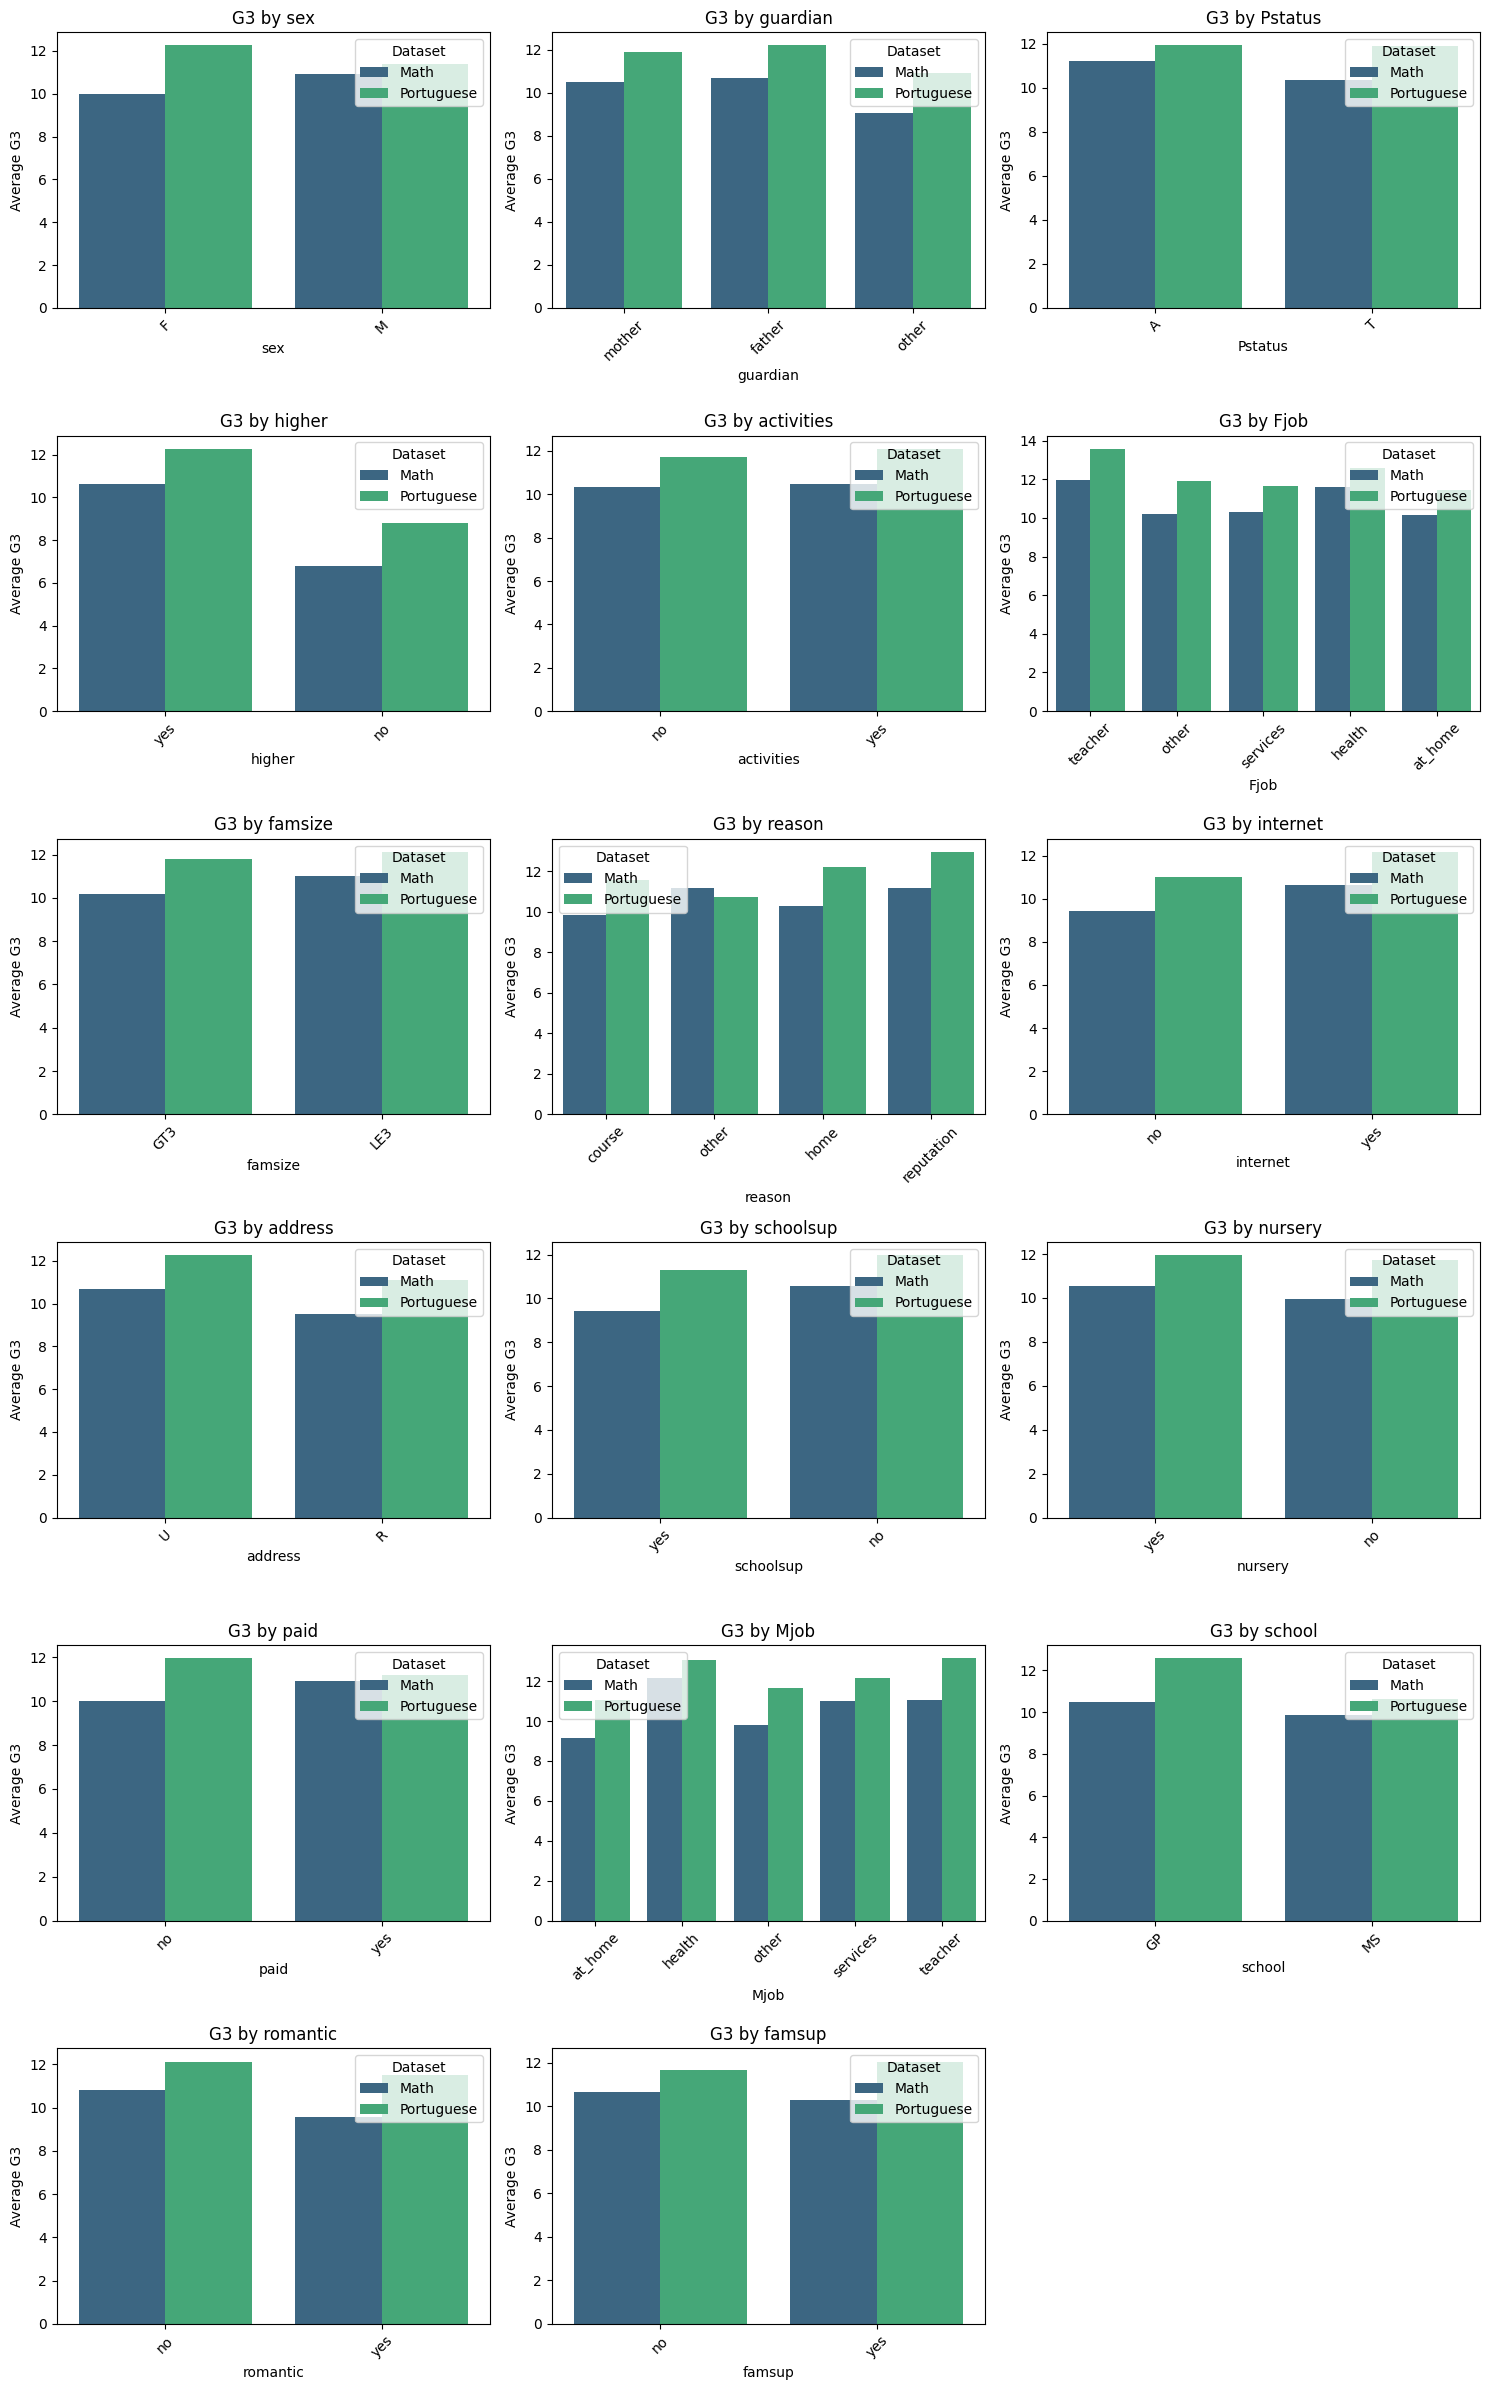


Analyzing Cardinality for student-mat Dataset
Feature: absences, Unique Values: 34
Feature: G3, Unique Values: 18
Feature: G1, Unique Values: 17
Feature: G2, Unique Values: 17
Feature: age, Unique Values: 8
Feature: Medu, Unique Values: 5
Feature: Fedu, Unique Values: 5
Feature: Mjob, Unique Values: 5
Feature: Fjob, Unique Values: 5
Feature: famrel, Unique Values: 5
Feature: freetime, Unique Values: 5
Feature: goout, Unique Values: 5
Feature: Dalc, Unique Values: 5
Feature: Walc, Unique Values: 5
Feature: health, Unique Values: 5
Feature: reason, Unique Values: 4
Feature: traveltime, Unique Values: 4
Feature: studytime, Unique Values: 4
Feature: failures, Unique Values: 4
Feature: guardian, Unique Values: 3
Feature: school, Unique Values: 2
Feature: sex, Unique Values: 2
Feature: address, Unique Values: 2
Feature: famsize, Unique Values: 2
Feature: Pstatus, Unique Values: 2
Feature: schoolsup, Unique Values: 2
Feature: famsup, Unique Values: 2
Feature: paid, Unique Values: 2
Feature: 

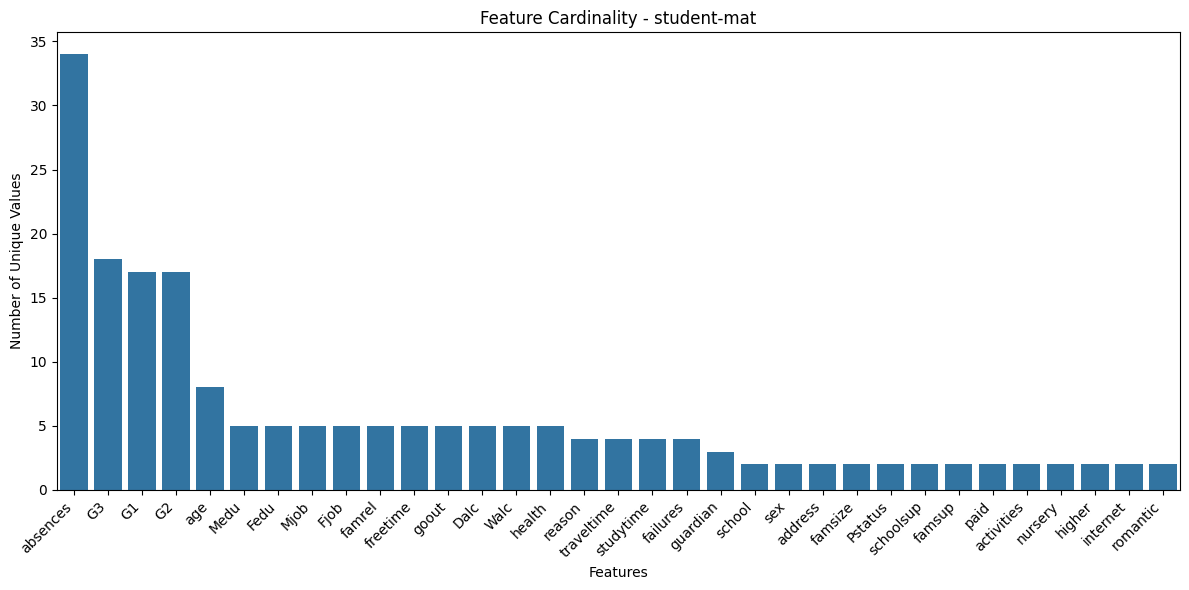


Analyzing Cardinality for student-por Dataset
Feature: absences, Unique Values: 24
Feature: G1, Unique Values: 17
Feature: G3, Unique Values: 17
Feature: G2, Unique Values: 16
Feature: age, Unique Values: 8
Feature: Medu, Unique Values: 5
Feature: Fedu, Unique Values: 5
Feature: Mjob, Unique Values: 5
Feature: Fjob, Unique Values: 5
Feature: famrel, Unique Values: 5
Feature: freetime, Unique Values: 5
Feature: goout, Unique Values: 5
Feature: Dalc, Unique Values: 5
Feature: Walc, Unique Values: 5
Feature: health, Unique Values: 5
Feature: reason, Unique Values: 4
Feature: traveltime, Unique Values: 4
Feature: studytime, Unique Values: 4
Feature: failures, Unique Values: 4
Feature: guardian, Unique Values: 3
Feature: school, Unique Values: 2
Feature: sex, Unique Values: 2
Feature: address, Unique Values: 2
Feature: famsize, Unique Values: 2
Feature: Pstatus, Unique Values: 2
Feature: schoolsup, Unique Values: 2
Feature: famsup, Unique Values: 2
Feature: paid, Unique Values: 2
Feature: 

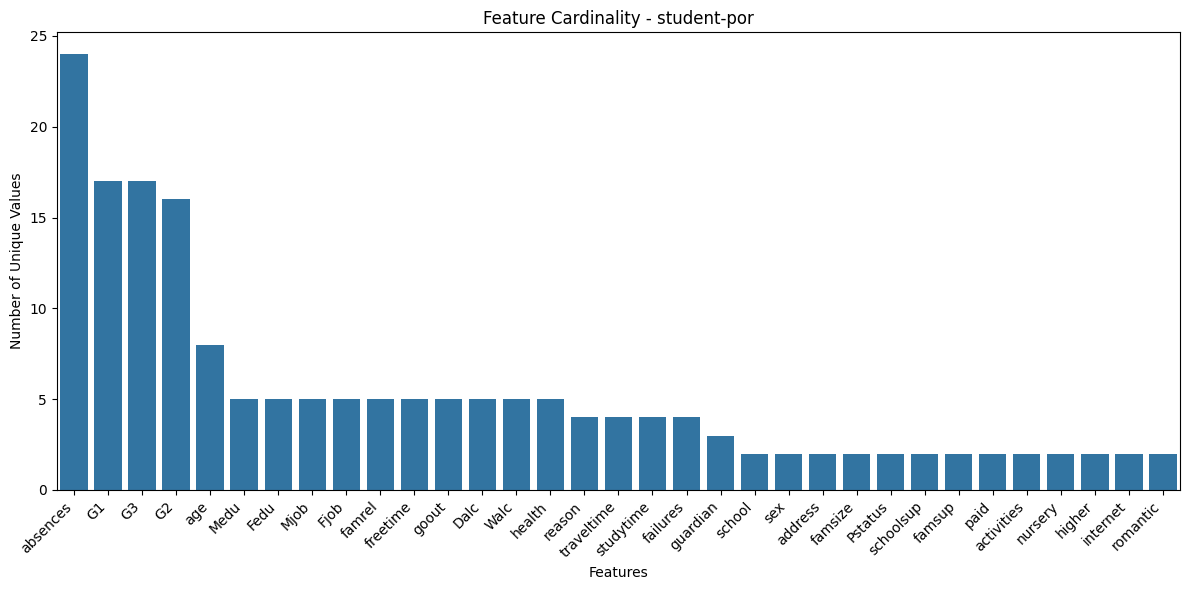

In [176]:
# Select only numeric columns
numeric_cols_mat = student_mat.select_dtypes(include=['number'])
numeric_cols_por = student_por.select_dtypes(include=['number'])

# Define a function to analyze covariance and correlation
def analyze_covariance_and_correlation(df, dataset_name):
    print(f"Analyzing Covariance and Correlation for {dataset_name} Dataset")
    
    # Continuous features
    continuous_features = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Covariance matrix
    covariance_matrix = df[continuous_features].cov()
    print(f"Covariance Matrix for {dataset_name}:\n", covariance_matrix)

    # Correlation matrix
    correlation_matrix = df[continuous_features].corr()
    print(f"Correlation Matrix for {dataset_name}:\n", correlation_matrix)
    
    # Correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"Correlation Heatmap - {dataset_name}")
    plt.show()

# Perform covariance and correlation analysis for both datasets
analyze_covariance_and_correlation(student_mat, "student-mat")
analyze_covariance_and_correlation(student_por, "student-por")

# Advanced Tabular Overview
def advanced_tabular_overview(df):
    # Summary of numerical columns
    numerical_summary = df.describe().transpose()
    numerical_summary['missing_values'] = df.isnull().sum()
    numerical_summary['unique_values'] = df.nunique()
    
    # Summary of categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    categorical_summary = pd.DataFrame({
        "unique_values": [df[col].nunique() for col in categorical_cols],
        "missing_values": [df[col].isnull().sum() for col in categorical_cols],
        "most_frequent_value": [df[col].mode()[0] if not df[col].mode().empty else None for col in categorical_cols],
    }, index=categorical_cols)
    
    print("\nNumerical Summary:")
    display(numerical_summary)
    print("\nCategorical Summary:")
    display(categorical_summary)

print("Advanced Overview for student-mat Dataset:")
advanced_tabular_overview(student_mat)

print("Advanced Overview for student-por Dataset:")
advanced_tabular_overview(student_por)

# Target Variable Exploration - G3
def explore_target_variable(df, dataset_name):
    plt.figure(figsize=(8, 6))
    sns.histplot(df['G3'], bins=15, kde=True, color="skyblue", edgecolor="black")
    plt.title(f"G3 Distribution in {dataset_name}")
    plt.xlabel("G3 (Final Grade)")
    plt.ylabel("Frequency")
    plt.show()

print("Exploring G3 (Final Grade) in student-mat Dataset:")
explore_target_variable(student_mat, "student-mat")

print("Exploring G3 (Final Grade) in student-por Dataset:")
explore_target_variable(student_por, "student-por")

# Feature Importance Exploration Function
def feature_importance_exploration(df, target_col):
    # Prepare data
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Encode categorical features column-wise
    label_encoders = {}
    for col in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le  # Store the encoder in case you need it later
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit decision tree
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Feature importance
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    print("\nFeature Importance:")
    display(importance)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance, x='Importance', y='Feature', color='b')
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

print("Feature Importance Exploration for student-mat Dataset:")
feature_importance_exploration(student_mat, 'G3')

print("Feature Importance Exploration for student-por Dataset:")
feature_importance_exploration(student_por, 'G3')

student_mat.hist(figsize=(12, 10), bins=20)
plt.tight_layout()
plt.show()

student_por.hist(figsize=(12, 10), bins=20)
plt.tight_layout()
plt.show()

X = student_mat.drop(columns=['G3'])
y = student_mat['G3']

# Identify overlapping categorical features
overlapping_categorical_features = list(
    set(student_mat.select_dtypes(include='object').columns) &
    set(student_por.select_dtypes(include='object').columns)
)

# Create bar plots for overlapping categorical features
num_cols = 3  # Number of columns in the plot grid
num_rows = -(-len(overlapping_categorical_features) // num_cols)  # Calculate rows needed

plt.figure(figsize=(5 * num_cols, 4 * num_rows))  # Adjust figure size for grid

for i, feature in enumerate(overlapping_categorical_features, 1):
    plt.subplot(num_rows, num_cols, i)
    combined_data = pd.concat([
        student_mat[[feature, 'G3']].assign(Dataset='Math'),
        student_por[[feature, 'G3']].assign(Dataset='Portuguese')
    ])
    sns.barplot(
        data=combined_data,
        x=feature,
        y='G3',
        hue='Dataset',
        errorbar=None,  # Updated to handle Seaborn's future versions
        palette="viridis"
    )
    plt.title(f"G3 by {feature}")
    plt.xlabel(feature)
    plt.ylabel("Average G3")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Define a function to analyze feature cardinality
def analyze_cardinality(df, dataset_name):
    print(f"\nAnalyzing Cardinality for {dataset_name} Dataset")
    
    # Calculate cardinality for all features
    cardinality = {col: df[col].nunique() for col in df.columns}
    
    # Display cardinality in a sorted order
    sorted_cardinality = sorted(cardinality.items(), key=lambda x: x[1], reverse=True)
    for feature, unique_values in sorted_cardinality:
        print(f"Feature: {feature}, Unique Values: {unique_values}")
    
    # Visualize cardinality
    plt.figure(figsize=(12, 6))
    sns.barplot(x=[item[0] for item in sorted_cardinality], y=[item[1] for item in sorted_cardinality])
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Feature Cardinality - {dataset_name}")
    plt.xlabel("Features")
    plt.ylabel("Number of Unique Values")
    plt.tight_layout()
    plt.show()

# Analyze cardinality for both datasets
analyze_cardinality(student_mat, "student-mat")
analyze_cardinality(student_por, "student-por")

### Continuous Features

#### Age
- Range: 15-22 years
- Mean (Math): 16.70 years
- Mean (Portuguese): 16.74 years
- Consistent across both datasets, typical high school age range

#### Parent Education (Medu & Fedu)
- Scale: 0-4 (likely representing education levels)
- Mean Mother's Education (Math): 2.75
- Mean Father's Education (Math): 2.52
- Mean Mother's Education (Portuguese): 2.51
- Mean Father's Education (Portuguese): 2.31
- Slight variations between datasets
- Moderate level of parental education observed

#### Study-Related Continuous Features
1. **Travel Time**
   - Scale: 1-4
   - Mean (Math): 1.45
   - Mean (Portuguese): 1.57
   - Suggests most students have relatively short travel times

2. **Study Time**
   - Scale: 1-4
   - Mean (Math): 2.04
   - Mean (Portuguese): 1.93
   - Indicates moderate study time dedication

3. **Academic Failures**
   - Range: 0-3
   - Mean (Math): 0.33
   - Mean (Portuguese): 0.22
   - Low average of academic failures

#### Social and Behavioral Features
1. **Family Relationship** (famrel)
   - Scale: 1-5
   - Mean (both datasets): ~3.94
   - Suggests generally positive family relationships

2. **Free Time** (freetime)
   - Scale: 1-5
   - Mean (Math): 3.24
   - Mean (Portuguese): 3.18
   - Moderate amount of free time

3. **Going Out** (goout)
   - Scale: 1-5
   - Mean (both datasets): ~3.10
   - Moderate social activity level

4. **Alcohol Consumption**
   - Daily Alcohol (Dalc): Mean ~1.48-1.50
   - Weekend Alcohol (Walc): Mean ~2.29-2.28
   - Low daily, moderate weekend alcohol consumption

#### Health and Absences
1. **Health Status**
   - Scale: 1-5
   - Mean (Math): 3.55
   - Mean (Portuguese): 3.54
   - Indicates generally good health

2. **Absences**
   - Math dataset: Mean 5.71, Max 75
   - Portuguese dataset: Mean 3.66, Max 32
   - Significant variation in student attendance

### Categorical Features

#### School and Demographics
1. **School**
   - Two types (likely different schools or tracks)
   - Most common: GP (Gabriel Pereira)

2. **Sex**
   - Binary (Male/Female)
   - Most common: Female

3. **Address**
   - Two types (Urban/Rural)
   - Most common: Urban (U)

4. **Family Size**
   - Two categories
   - Most common: GT3 (>3 family members)

5. **Parent Status**
   - Two categories
   - Most common: Together (T)

#### Parental and Educational Factors
1. **Parent Jobs** (Mjob & Fjob)
   - Five job categories
   - Most common category: "other" for both mothers and fathers

2. **Reason for School Choice**
   - Four categories
   - Most common: Course selection

3. **Guardian**
   - Three categories
   - Most common: Mother

#### Support and Activities
1. **School Support**
   - Most students: No additional school support

2. **Family Support**
   - Most students: Have family support (yes)

3. **Paid Classes**
   - Most students: No paid classes

4. **Extra-Curricular Activities**
   - Slightly varies between datasets
   - Mostly balanced participation

5. **Higher Education Intention**
   - Most students: Interested in higher education

6. **Internet Access**
   - Most students: Have internet access

7. **Romantic Relationship**
   - Most students: Not in a romantic relationship

### Key Generalizations
1. Typical high school students with moderate family support
2. Generally positive health and family relationships
3. Moderate study time and social activities
4. Low daily, moderate weekend alcohol consumption
5. Urban students with intention for higher education
6. Previous grades are the strongest predictor of final grades
7. Absences significantly impact academic performance

### Identifying Data Quality Issues

- There are no missing values, very few outliers, and cardinality isn't an issue for the most part

## Experimental Design & Data Preprocessing

### Merging the files

In [177]:
# Merge the normalized datasets
student_dataset = pd.concat([student_mat, student_por], ignore_index=True)

# Save the merged dataset to a CSV file
student_dataset.to_csv('Data/student_dataset.csv', index=False)

### Categorical to Numeric + Normalization

In [178]:
# Load the original dataset (So that categorical columns may be read as 'object')
student_dataset = pd.read_csv("Data/student_dataset.csv")

# Identify categorical and numerical columns
categorical_columns = student_dataset.select_dtypes(include=["object"]).columns
numerical_columns = student_dataset.select_dtypes(include=["float64", "int64"]).columns

# Binary Encoding for High-Cardinality Features
high_cardinality_columns = ['Mjob', 'Fjob']
binary_encoder = BinaryEncoder()

for col in high_cardinality_columns:
    if col in categorical_columns:  # Check if the column is categorical
        # Encode high-cardinality categorical columns
        encoded_columns = binary_encoder.fit_transform(student_dataset[[col]])
        encoded_columns.columns = [f"{col}_binary_{i}" for i in range(encoded_columns.shape[1])]
        # Replace the original column with encoded columns
        student_dataset = pd.concat([student_dataset.drop(columns=[col]), encoded_columns], axis=1)

# One-Hot Encoding for Low-Cardinality Features
low_cardinality_columns = ['school', 'sex', 'address', 'famsize', 'Pstatus']
student_dataset = pd.get_dummies(student_dataset, columns=low_cardinality_columns, drop_first=True)

# Update numerical columns after encoding
numerical_columns = student_dataset.select_dtypes(include=["float64", "int64"]).columns

# Normalize Numerical Columns
scaler = MinMaxScaler()
student_dataset[numerical_columns] = scaler.fit_transform(student_dataset[numerical_columns])

# Save the encoded and normalized dataset
student_dataset.to_csv("Normalized/normalized_encoded_student_dataset.csv", index=False)

### Exploratory Data Analysis

#### Summary Stattistics + Visualization

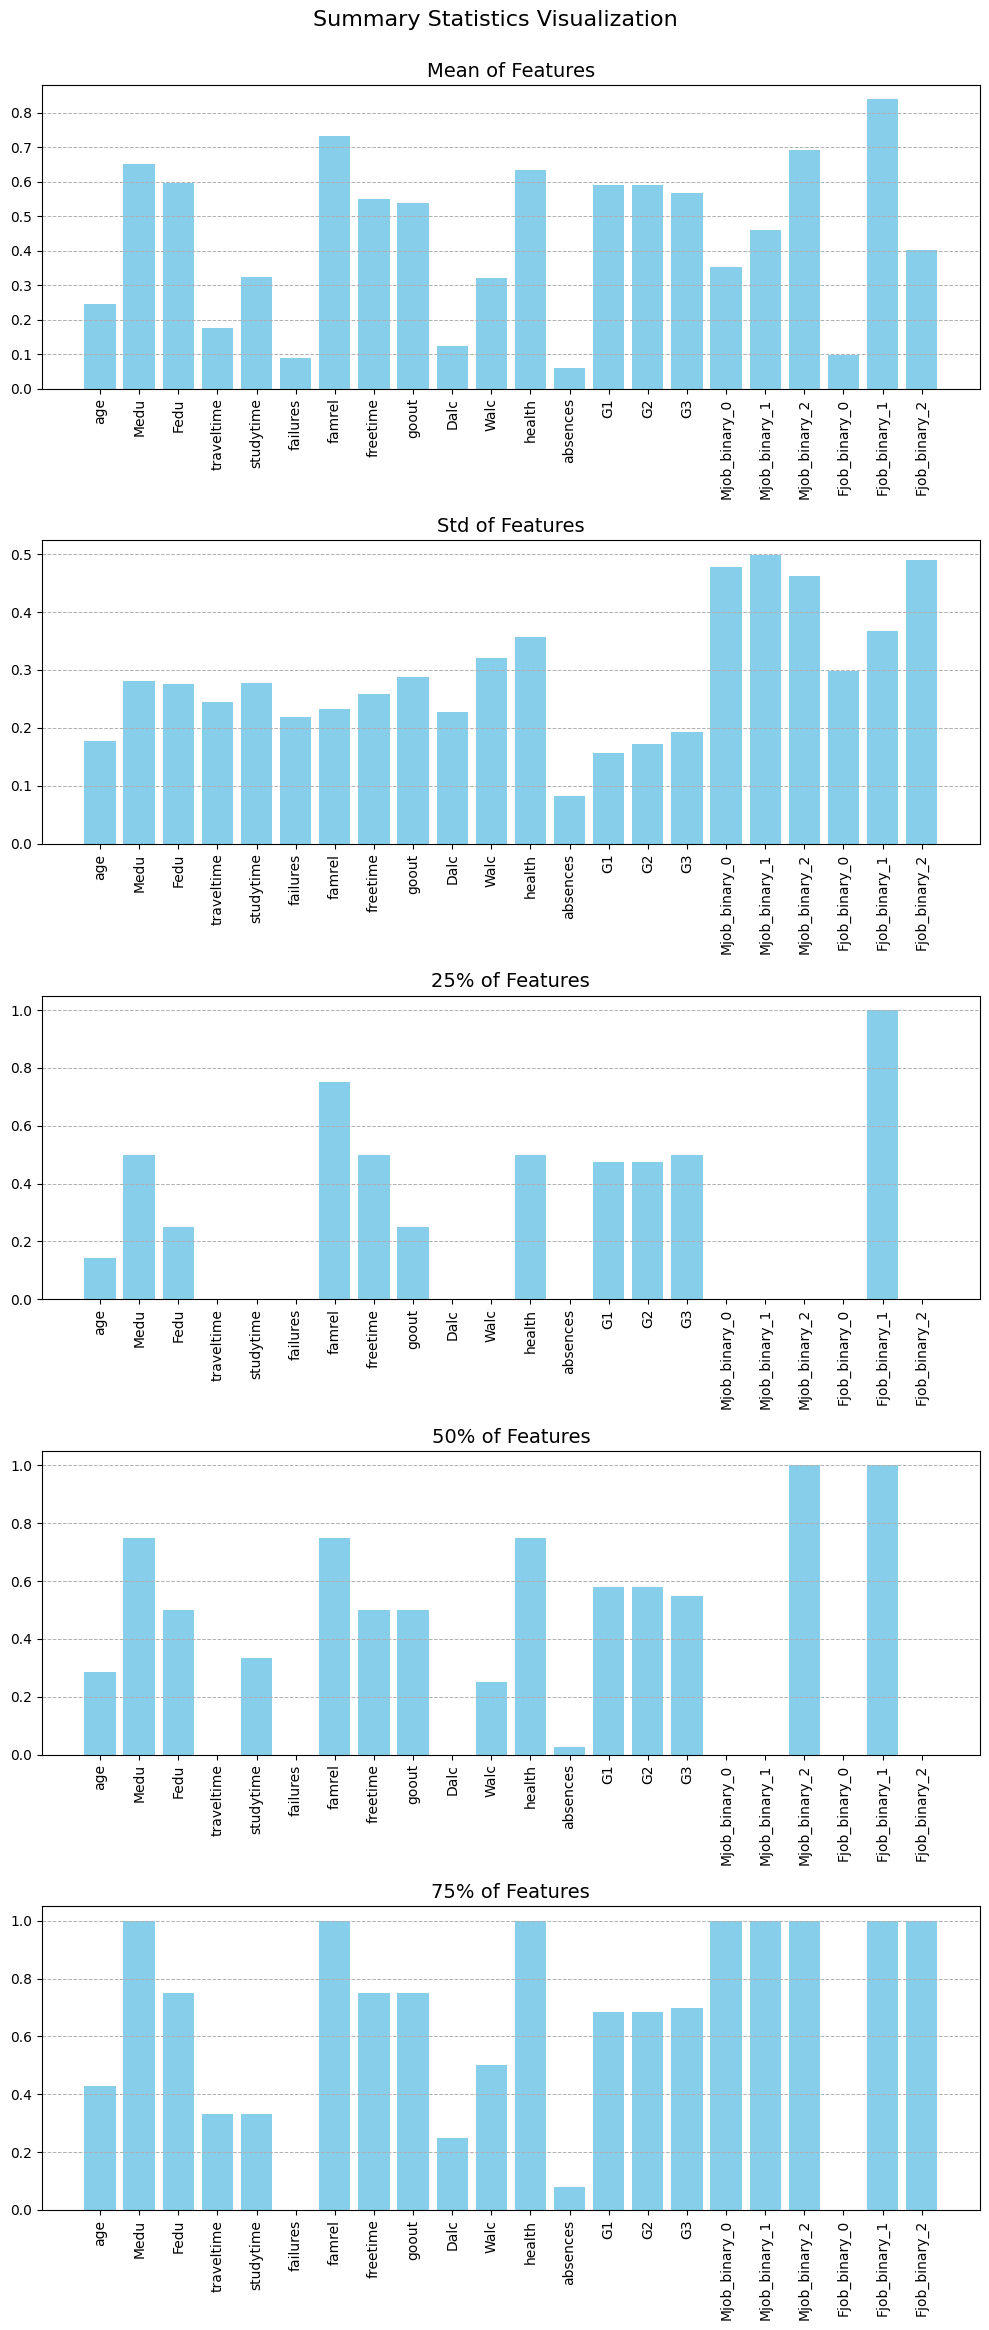

In [179]:
# Load the normalized and encoded dataset
file_path = "Normalized/normalized_encoded_student_dataset.csv"
student_dataset = pd.read_csv(file_path)

# Generate summary statistics for all numerical columns
summary_stats = student_dataset.describe()

# Save the summary statistics to a CSV file for easier reference
summary_stats.to_csv("summary_statistics.csv", index=True)

stats_to_plot = summary_stats.loc[["mean", "std", "25%", "50%", "75%"]]

# Visualize summary statistics
fig, axes = plt.subplots(len(stats_to_plot.index), 1, figsize=(10, 25), tight_layout=True)

for i, stat in enumerate(stats_to_plot.index):
    axes[i].bar(stats_to_plot.columns, stats_to_plot.loc[stat], color='skyblue')
    axes[i].set_title(f'{stat.capitalize()} of Features', fontsize=14)
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].grid(axis='y', linestyle='--', linewidth=0.7)

# Add a main title
plt.suptitle('Summary Statistics Visualization', fontsize=16, y=0.93)

# Adjust spacing to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.5)

plt.savefig("filtered_summary_statistics_visualization_fixed.png")
plt.show()

### Feature Engineering

Encoding non-numeric columns: Index(['reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object')


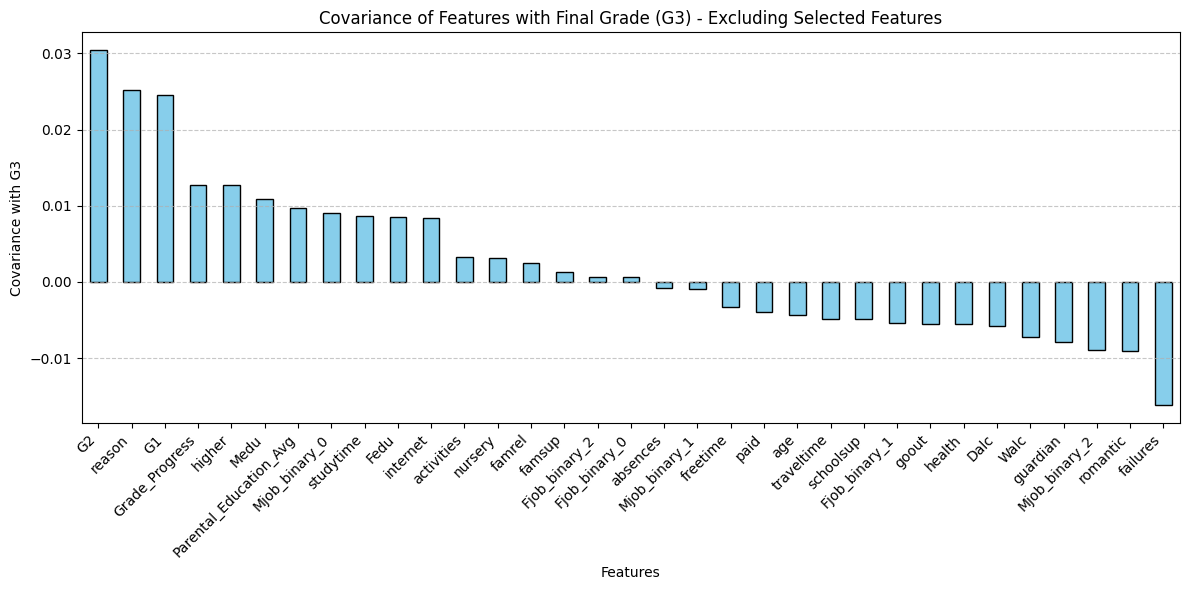

In [180]:
# Load the dataset
student_dataset = pd.read_csv("Normalized/normalized_encoded_student_dataset.csv")

# Convert all categorical columns to numeric
# Identify non-numeric columns
non_numeric_columns = student_dataset.select_dtypes(include=["object"]).columns

# Encode non-numeric columns
if len(non_numeric_columns) > 0:
    print(f"Encoding non-numeric columns: {non_numeric_columns}")
    label_encoder = LabelEncoder()
    for col in non_numeric_columns:
        student_dataset[col] = label_encoder.fit_transform(student_dataset[col])

# Add new features
# 1. Parental Education Average
student_dataset['Parental_Education_Avg'] = (student_dataset['Medu'] + student_dataset['Fedu']) / 2

# 2. Study Effort vs. Travel Time
# Avoid division by zero by replacing 0 in 'traveltime' with a small value
student_dataset['traveltime'] = student_dataset['traveltime'].replace(0, 1e-6)
student_dataset['Study_Effort_Per_Travel'] = student_dataset['studytime'] / student_dataset['traveltime']

# 3. Social & Free Time Ratio
# Avoid division by zero by replacing 0 in 'freetime' with a small value
student_dataset['freetime'] = student_dataset['freetime'].replace(0, 1e-6)
student_dataset['Social_Free_Time_Ratio'] = student_dataset['goout'] / student_dataset['freetime']

# 4. Weekend to Daily Alcohol Ratio
# Avoid division by zero by replacing 0 in 'Dalc' with a small value
student_dataset['Dalc'] = student_dataset['Dalc'].replace(0, 1e-6)
student_dataset['Weekend_vs_Daily_Alcohol'] = student_dataset['Walc'] / student_dataset['Dalc']

# 5. Absenteeism Impact
# Avoid division by zero by replacing 0 in 'health' with a small value
student_dataset['health'] = student_dataset['health'].replace(0, 1e-6)
student_dataset['Absenteeism_vs_Health'] = student_dataset['absences'] / student_dataset['health']

# 6. Final Grade Progress
student_dataset['Grade_Progress'] = (student_dataset['G2'] - student_dataset['G1']) + (student_dataset['G3'] - student_dataset['G2'])

# Save the updated dataset
student_dataset.to_csv("Normalized/normalized_encoded_student_dataset_with_features.csv", index=False)


# Load the dataset (replace with the appropriate path if needed)
file_path = "Normalized/normalized_encoded_student_dataset_with_features.csv"
student_dataset = pd.read_csv(file_path)

# Step 1: Drop the features excluded from the covariance plot
features_to_exclude = [
    "Study_Effort_Per_Travel", 
    "Weekend_vs_Daily_Alcohol", 
    "Absenteeism_vs_Health", 
    "Social_Free_Time_Ratio"
]

# Ensure all columns are numeric before computing the covariance matrix
student_dataset_numeric = student_dataset.drop(columns=features_to_exclude, errors="ignore").select_dtypes(include=["float64", "int64"])

# Step 2: Compute the covariance matrix
covariance_matrix = student_dataset_numeric.cov()

# Calculate the covariance of each feature with the target variable G3
target_covariance = covariance_matrix['G3'].drop('G3')  # Drop G3 itself to avoid self-covariance

# Step 3: Sort covariance values in descending order
sorted_covariance = target_covariance.sort_values(ascending=False)

# Step 4: Plot the covariance as a bar plot
plt.figure(figsize=(12, 6))
sorted_covariance.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Covariance of Features with Final Grade (G3) - Excluding Selected Features")
plt.xlabel("Features")
plt.ylabel("Covariance with G3")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Save the plot as a file (optional)
plt.savefig("covariance_with_G3_barplot_filtered.png", dpi=300)

# Display the plot
plt.show()

# No Features are so low covariance that they are irrelevant 

### Data Splitting

In [181]:
# Load the dataset
student_dataset = pd.read_csv("Normalized/normalized_encoded_student_dataset_with_features.csv")

# Exclude high-correlation features (G1 and G2)
high_correlation_features = ["G1", "G2"]  # Features to exclude
columns_to_drop = high_correlation_features + ["G3"]  # G3 is the target variable

# Define features (X) and target (y)
X = student_dataset.drop(columns=columns_to_drop)  # Exclude high-correlation features and target
y = student_dataset["G3"]  # Use G3 as the continuous target variable

# Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert y to float for regression
y_train_continuous = y_train.astype(float)
y_test_continuous = y_test.astype(float)

## Model Implementation & Comparisons

### Chosen Models

The dataset's target variable is numeric, its features numeric & categorical. When it comes to predicting student success using ML models, identify key performance drivers, and improve educational interventions, the chosen algorithms offer distinct advantages, relatively tailored to the dataset's characteristics.

### Linear Regression with Gradient Descent

In [182]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

# Initialize the model
linear_regression = SGDRegressor(
    max_iter=1000,
    learning_rate="adaptive",
    eta0=0.01,  # Initial learning rate
    penalty="l2",  # Regularization
    alpha=0.0001,  # Regularization strength
    random_state=42
)

# Train the model
linear_regression.fit(X_train_scaled, y_train_continuous)

# Predict on the test set
y_pred_lr = linear_regression.predict(X_test_scaled)

# Evaluate the model
mse_linear = mean_squared_error(y_test_continuous, y_pred_lr)
print(f"Linear Regression MSE: {mse_linear}")

# Display sample predictions and actual values
print("Sample predictions:", y_pred_lr[:10])
print("Sample actual values:", y_test_continuous.iloc[:10].values)

Linear Regression MSE: 0.018041093409129957
Sample predictions: [0.67718681 0.58745964 0.74482755 0.62276874 0.51028658 0.5949846
 0.56059245 0.62971422 0.69116197 0.59784552]
Sample actual values: [0.7  0.55 0.7  0.65 0.55 0.65 0.55 0.65 0.7  0.65]


### K - Nearest Neighbors

In [183]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Initialize the model
knn_model = KNeighborsRegressor(n_neighbors=5)

# Train the model
knn_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_knn = knn_model.predict(X_test_scaled)

# Evaluate the model
mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f"k-NN Regression MSE: {mse_knn}")

k-NN Regression MSE: 0.024856687898089175


### Support Vector Machines

In [184]:
from sklearn.svm import SVR

# Initialize the model
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Train the model
svm_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate the model
mse_svm = mean_squared_error(y_test, y_pred_svm)
print(f"SVM Regression MSE: {mse_svm}")

SVM Regression MSE: 0.015205735002793703


### Decision Tree Regressor

In [185]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the model
dt_model = DecisionTreeRegressor(random_state=42, max_depth=5)

# Train the model
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
mse_dt = mean_squared_error(y_test, y_pred_dt)
print(f"Decision Tree Regression MSE: {mse_dt}")

Decision Tree Regression MSE: 0.012483580594237103


### Random Forest Regressor

In [186]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest Regression MSE: {mse_rf}")

Random Forest Regression MSE: 0.003615292993630573


### ANN - MLP

In [187]:
from sklearn.neural_network import MLPRegressor

# Initialize the model
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

# Train the model
mlp_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_mlp = mlp_model.predict(X_test_scaled)

# Evaluate the model
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
print(f"MLP Regression MSE: {mse_mlp}")

MLP Regression MSE: 0.03634832689951611


### ANN - FNN 

In [188]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Load dataset
student_dataset = pd.read_csv("Normalized/normalized_encoded_student_dataset_with_features.csv")

# Features and Target
X = student_dataset.drop(columns=["G3"])
y = student_dataset["G3"]

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define FNN Model
class FNNModel(nn.Module):
    def __init__(self, input_size):
        super(FNNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model Initialization
input_size = X_train_tensor.shape[1]
fnn_model = FNNModel(input_size)

# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(fnn_model.parameters(), lr=0.001)

# Training Loop
epochs = 100
for epoch in range(epochs):
    fnn_model.train()
    optimizer.zero_grad()
    
    # Forward Pass
    outputs = fnn_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Evaluate Model
fnn_model.eval()
with torch.no_grad():
    y_pred_fnn = fnn_model(X_test_tensor)
    mse_fnn = criterion(y_pred_fnn, y_test_tensor).item()
    print(f"FNN MSE on Test Set: {mse_fnn:.4f}")

Epoch [10/100], Loss: 0.0431
Epoch [20/100], Loss: 0.0411
Epoch [30/100], Loss: 0.0432
Epoch [40/100], Loss: 0.0361
Epoch [50/100], Loss: 0.0311
Epoch [60/100], Loss: 0.0267
Epoch [70/100], Loss: 0.0242
Epoch [80/100], Loss: 0.0213
Epoch [90/100], Loss: 0.0184
Epoch [100/100], Loss: 0.0160
FNN MSE on Test Set: 0.0167


### ANN - RNN with GRU

In [189]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Load dataset
student_dataset = pd.read_csv("Normalized/normalized_encoded_student_dataset_with_features.csv")

# Features and Target
X = student_dataset.drop(columns=["G3"])
y = student_dataset["G3"]

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Add sequence dimension
X_train_tensor = X_train_tensor.unsqueeze(1)  # Shape: (batch_size, sequence_length=1, input_size)
X_test_tensor = X_test_tensor.unsqueeze(1)

# Define GRU Model
class GRUNet(nn.Module):
    def __init__(self, input_size):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size=64, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.gru(x)  # Output from GRU
        out = self.fc(out[:, -1, :])  # Use the last time step's output
        return out

# Initialize Model
input_size = X_train_tensor.shape[2]
gru_model = GRUNet(input_size)

# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

# Training Loop
epochs = 100
for epoch in range(epochs):
    gru_model.train()
    optimizer.zero_grad()
    
    # Forward Pass
    outputs = gru_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Evaluate Model
gru_model.eval()
with torch.no_grad():
    y_pred_gru = gru_model(X_test_tensor)
    mse_gru = criterion(y_pred_gru, y_test_tensor).item()
    print(f"GRU MSE on Test Set: {mse_gru:.4f}")

Epoch [10/100], Loss: 0.1875
Epoch [20/100], Loss: 0.0602
Epoch [30/100], Loss: 0.0410
Epoch [40/100], Loss: 0.0441
Epoch [50/100], Loss: 0.0366
Epoch [60/100], Loss: 0.0350
Epoch [70/100], Loss: 0.0338
Epoch [80/100], Loss: 0.0329
Epoch [90/100], Loss: 0.0298
Epoch [100/100], Loss: 0.0286
GRU MSE on Test Set: 0.0309


## Comparisons

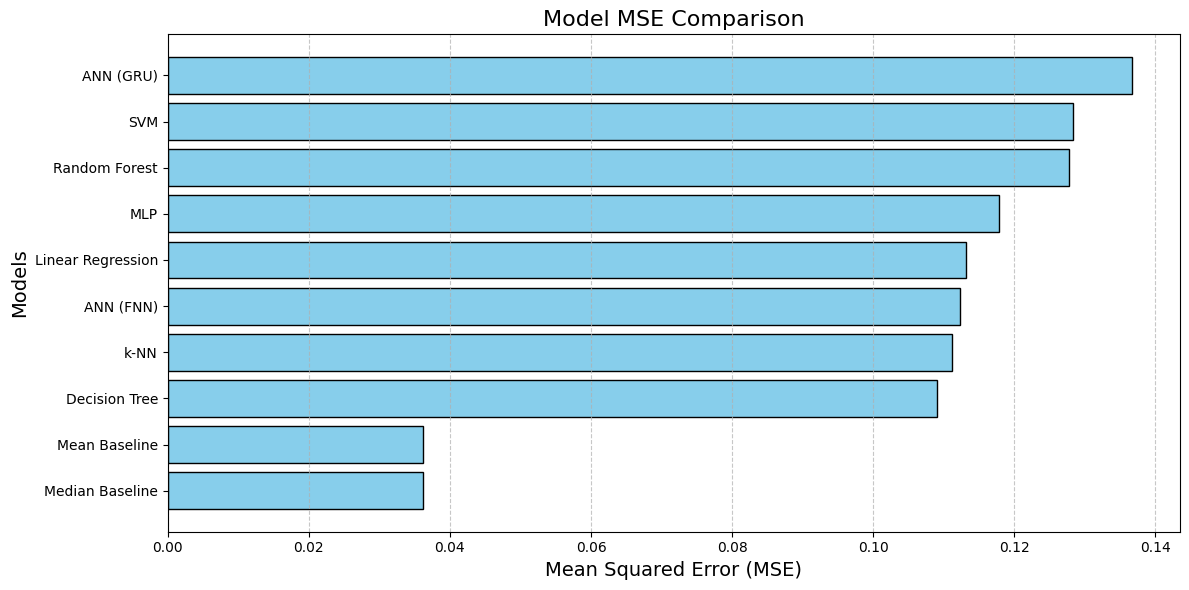

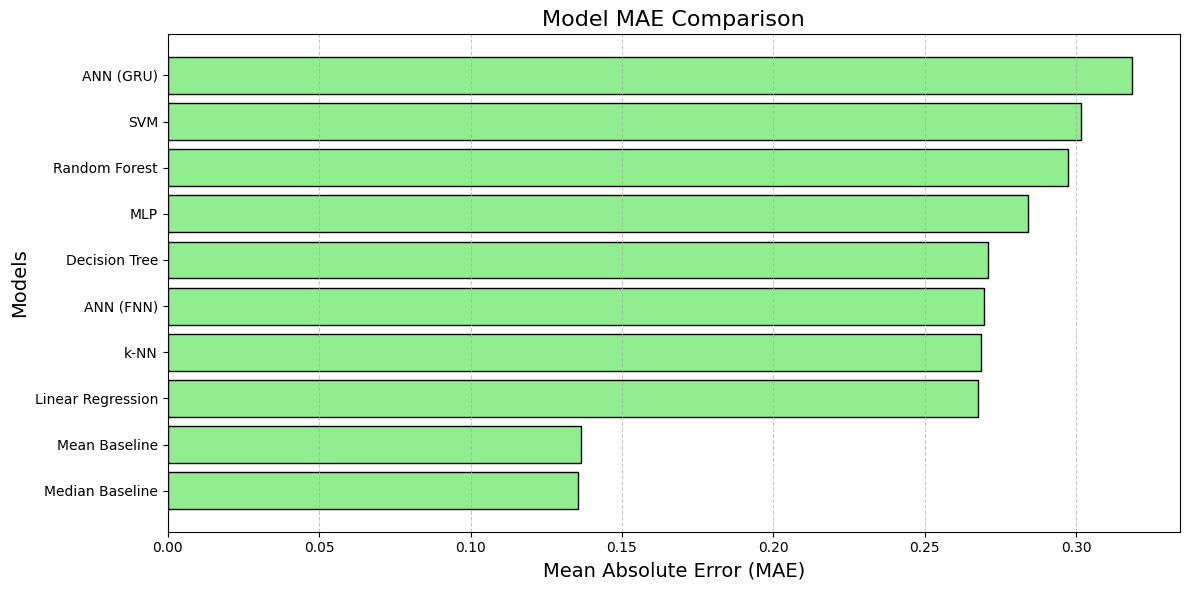

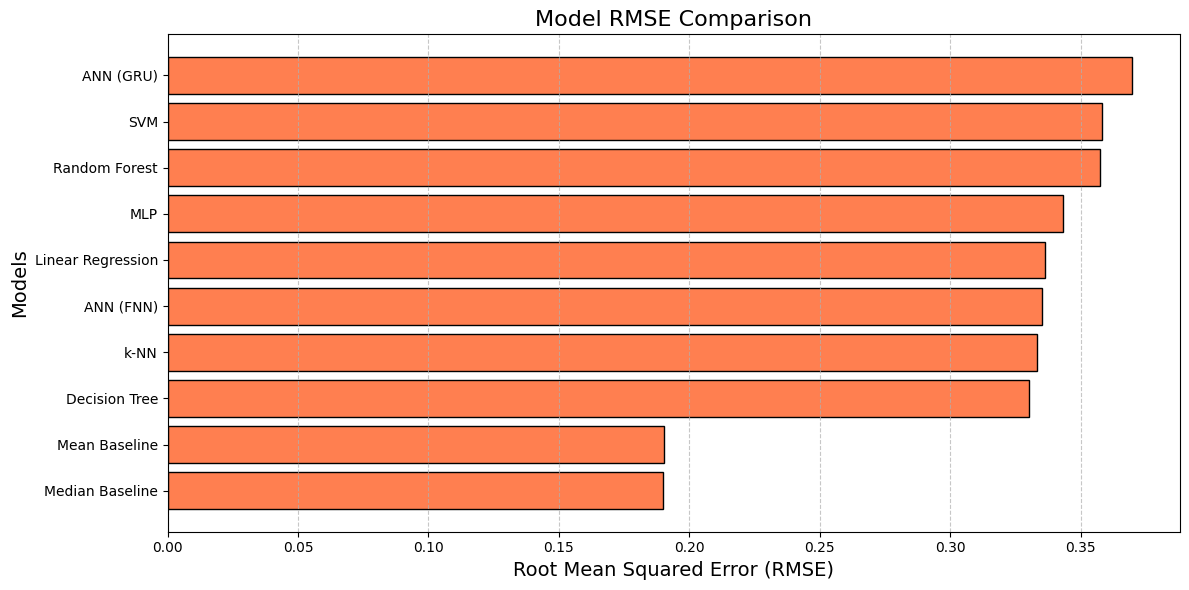

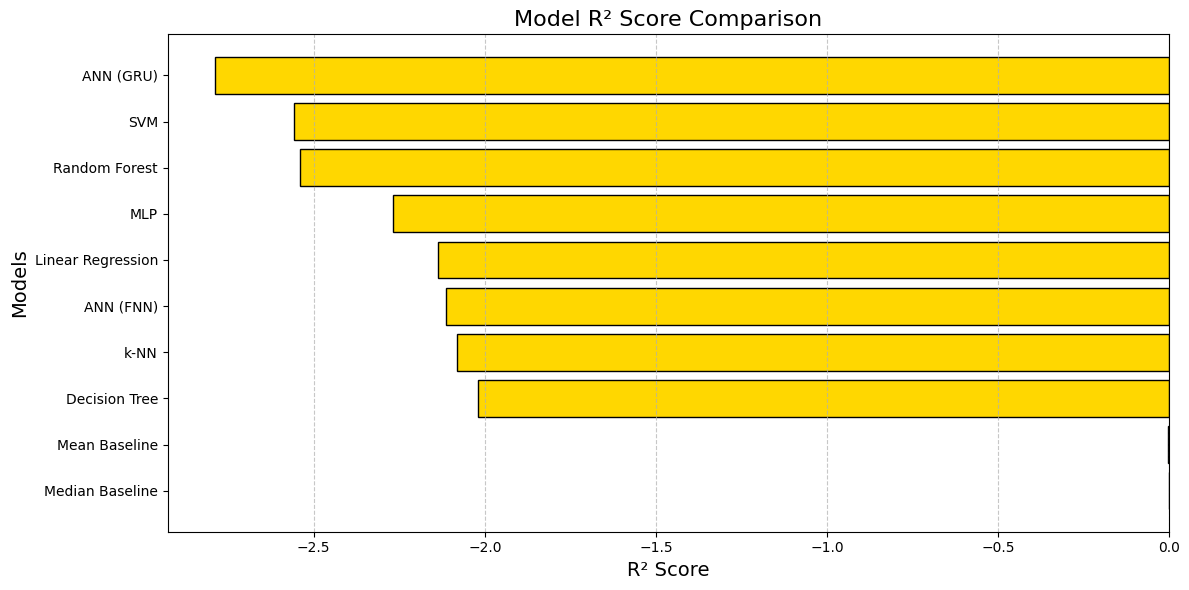

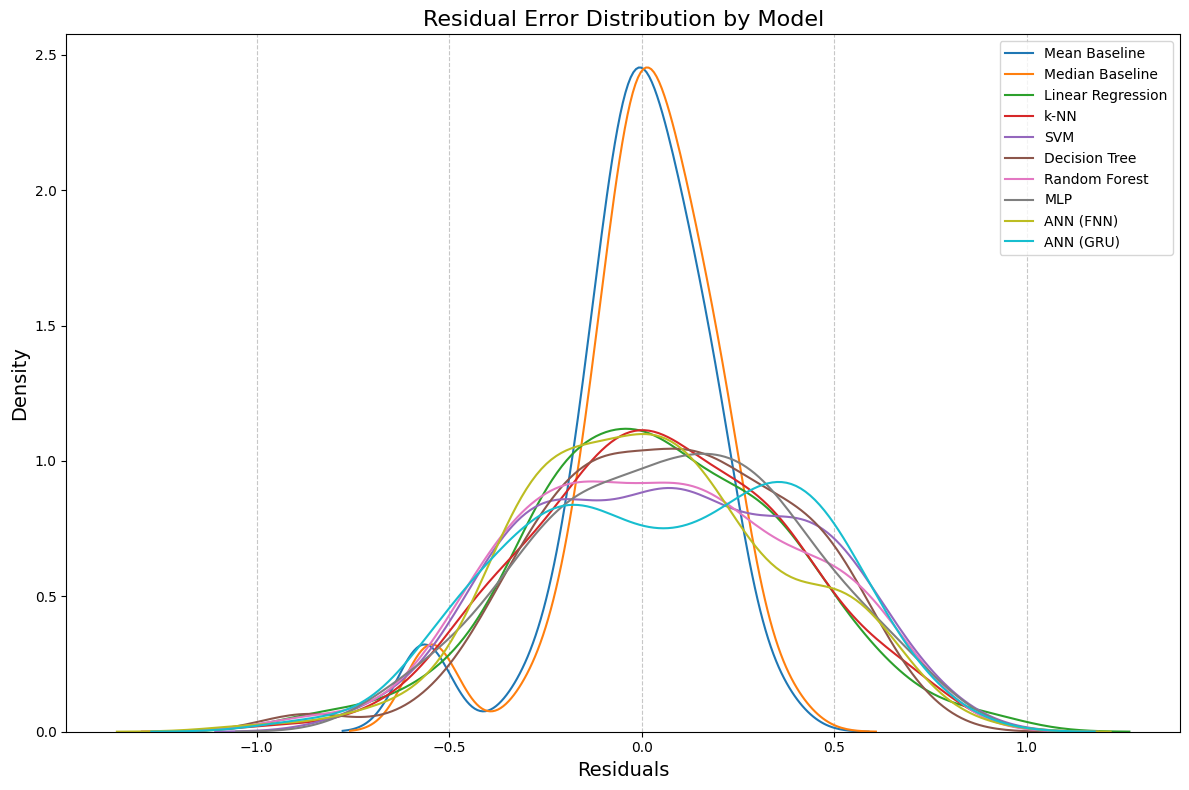

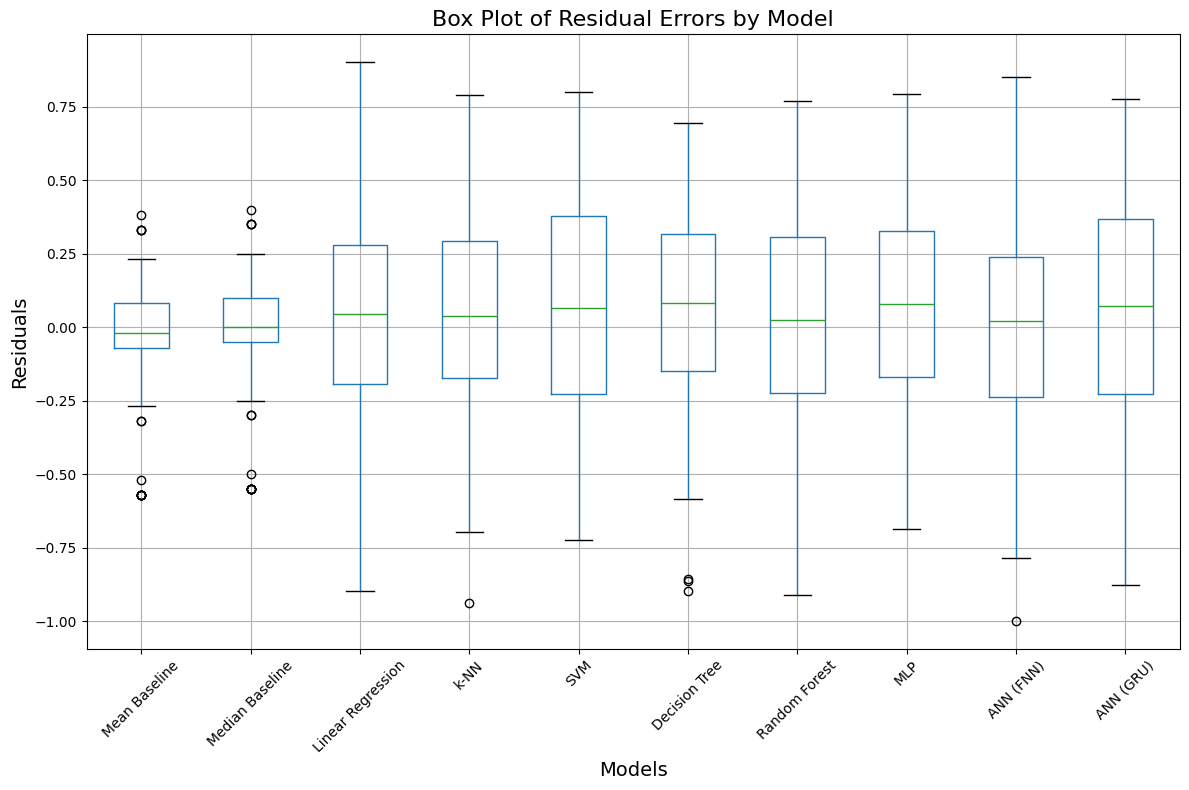

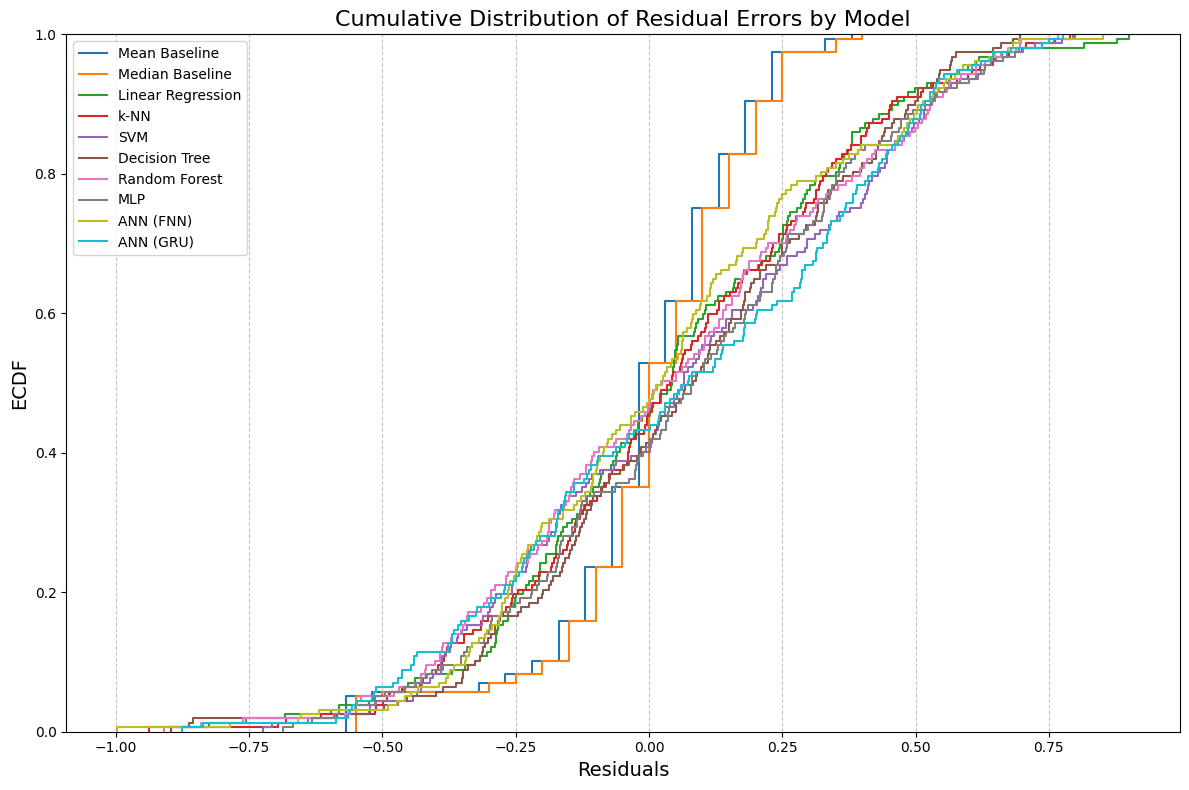

In [192]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load your dataset
file_path = "Normalized/normalized_encoded_student_dataset_with_features.csv"
student_dataset = pd.read_csv(file_path)

# Define features and target
X = student_dataset.drop(columns=["G3"])  # Features
y = student_dataset["G3"]  # Target (continuous variable)

# Split the dataset into train and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert target values to numeric (if necessary)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Placeholder model predictions (replace with actual predictions from your models)
predictions = {
    "Mean Baseline": np.full_like(y_test, y_train.mean()),
    "Median Baseline": np.full_like(y_test, y_train.median()),
    "Linear Regression": np.random.random(size=len(y_test)),  # Replace with actual predictions
    "k-NN": np.random.random(size=len(y_test)),  # Replace with actual predictions
    "SVM": np.random.random(size=len(y_test)),  # Replace with actual predictions
    "Decision Tree": np.random.random(size=len(y_test)),  # Replace with actual predictions
    "Random Forest": np.random.random(size=len(y_test)),  # Replace with actual predictions
    "MLP": np.random.random(size=len(y_test)),  # Replace with actual predictions
    "ANN (FNN)": np.random.random(size=len(y_test)),  # Replace with actual predictions
    "ANN (GRU)": np.random.random(size=len(y_test)),  # Replace with actual predictions
}

# Calculate evaluation metrics
mse_scores = {}
mae_scores = {}
rmse_scores = {}
r2_scores = {}
errors = {}

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

for model, y_pred in predictions.items():
    mse_scores[model] = mean_squared_error(y_test, y_pred)
    mae_scores[model] = mean_absolute_error(y_test, y_pred)
    rmse_scores[model] = np.sqrt(mse_scores[model])
    r2_scores[model] = r2_score(y_test, y_pred)
    errors[model] = y_test - y_pred

# Sort metrics for visualization
sorted_mse = dict(sorted(mse_scores.items(), key=lambda item: item[1]))
sorted_mae = dict(sorted(mae_scores.items(), key=lambda item: item[1]))
sorted_rmse = dict(sorted(rmse_scores.items(), key=lambda item: item[1]))
sorted_r2 = dict(sorted(r2_scores.items(), key=lambda item: item[1], reverse=True))

# Bar Plots for Metrics
plt.figure(figsize=(12, 6))
plt.barh(list(sorted_mse.keys()), list(sorted_mse.values()), color='skyblue', edgecolor='black')
plt.title("Model MSE Comparison", fontsize=16)
plt.xlabel("Mean Squared Error (MSE)", fontsize=14)
plt.ylabel("Models", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.barh(list(sorted_mae.keys()), list(sorted_mae.values()), color='lightgreen', edgecolor='black')
plt.title("Model MAE Comparison", fontsize=16)
plt.xlabel("Mean Absolute Error (MAE)", fontsize=14)
plt.ylabel("Models", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.barh(list(sorted_rmse.keys()), list(sorted_rmse.values()), color='coral', edgecolor='black')
plt.title("Model RMSE Comparison", fontsize=16)
plt.xlabel("Root Mean Squared Error (RMSE)", fontsize=14)
plt.ylabel("Models", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.barh(list(sorted_r2.keys()), list(sorted_r2.values()), color='gold', edgecolor='black')
plt.title("Model R² Score Comparison", fontsize=16)
plt.xlabel("R² Score", fontsize=14)
plt.ylabel("Models", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Residual Error Distribution Plot
plt.figure(figsize=(12, 8))
for model, residuals in errors.items():
    sns.kdeplot(residuals, label=model)
plt.title("Residual Error Distribution by Model", fontsize=16)
plt.xlabel("Residuals", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Box Plot of Errors
plt.figure(figsize=(12, 8))
error_df = pd.DataFrame(errors)
error_df.boxplot()
plt.title("Box Plot of Residual Errors by Model", fontsize=16)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Residuals", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Cumulative Error Distribution
plt.figure(figsize=(12, 8))
for model, residuals in errors.items():
    sns.ecdfplot(residuals, label=model)
plt.title("Cumulative Distribution of Residual Errors by Model", fontsize=16)
plt.xlabel("Residuals", fontsize=14)
plt.ylabel("ECDF", fontsize=14)
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()